In [1]:
# import the necessary packages
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from PIL import Image
import sys

In [2]:
#select the mode of panoptic
#set the path of picture/mask/label
panoptic_mode = int(input("Select the mode of panoptic: 1 for DETR, 2 for SETR: "))
if panoptic_mode == 1:
    Filepath = './DETR_result/'
    image1 = cv2.imread('image1.jpg')
    image2 = cv2.imread('image2.jpg')
    mask_label_path1 = Filepath + 'image1/'
    mask_label_path2 = Filepath + 'image2/'
    
elif panoptic_mode == 2:
    Filepath = './SETR_result/'
    image1 = cv2.imread('image1.jpg')
    image2 = cv2.imread('image2.jpg')
    mask_label_path1 = Filepath + 'image1/'
    mask_label_path2 = Filepath + 'image2/'

Select the mode of panoptic: 1 for DETR, 2 for SETR:  2


In [3]:
# Function to read the masks and labels from the mask_label_path
def read_masks_and_labels(mask_label_path):
    labels = []
    categories = []

    with open(mask_label_path + 'image_categories.txt', 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split(',')
            label = parts[0].split(':')[1].strip()
            category = parts[1].split(':')[1].strip()
            labels.append(int(label))
            categories.append(category)

    mask_dict = {}
    
    for i, ID in enumerate(labels):
        filename = 'mask_class_' + str(ID) + '.png'
        mask = cv2.imread(mask_label_path + filename, cv2.IMREAD_GRAYSCALE)
        masks = np.array(mask)
        mask_dict[i] = {'labels': labels[i], 'categories': categories[i], 'masks': masks}
        
    return mask_dict
    
# Function to extract and print categories from the mask dictionary
def print_categories(mask_dict, dict_name):
    categories = [mask_dict[key]['categories'] for key in mask_dict]
    print(f"Length of {dict_name}: {len(mask_dict)}")
    print(f"Categories in {dict_name}: {categories}")
    
def calculate_mask_percentage(mask_dict):
    for key in mask_dict:
        mask = mask_dict[key]['masks']
        total_pixels = mask.size
        masked_pixels = np.sum(mask > 0)
        mask_percentage = (masked_pixels / total_pixels) * 100
        mask_dict[key]['mask_percentage'] = mask_percentage

def print_mask_percentages(mask_dict):
    for key in mask_dict:
        label = mask_dict[key]['labels']
        category = mask_dict[key]['categories']
        mask_percentage = mask_dict[key]['mask_percentage']
        print(f"Label: {label}, Category: {category}, Mask Percentage: {mask_percentage:.2f}%")

In [4]:
mask_dict1 = read_masks_and_labels(mask_label_path1)
mask_dict2 = read_masks_and_labels(mask_label_path2)

# Calculate mask percentages
calculate_mask_percentage(mask_dict1)
calculate_mask_percentage(mask_dict2)

# Print mask percentages
print("Mask Percentages for mask_dict1:")
print_mask_percentages(mask_dict1)

print("Mask Percentages for mask_dict2:")
print_mask_percentages(mask_dict2)

Mask Percentages for mask_dict1:
Label: 0, Category: road, Mask Percentage: 21.38%
Label: 1, Category: sidewalk, Mask Percentage: 0.57%
Label: 2, Category: building, Mask Percentage: 16.37%
Label: 4, Category: fence, Mask Percentage: 0.04%
Label: 5, Category: pole, Mask Percentage: 0.16%
Label: 6, Category: traffic light, Mask Percentage: 0.01%
Label: 7, Category: traffic sign, Mask Percentage: 0.01%
Label: 8, Category: vegetation, Mask Percentage: 12.78%
Label: 9, Category: terrain, Mask Percentage: 5.41%
Label: 10, Category: sky, Mask Percentage: 34.65%
Label: 11, Category: person, Mask Percentage: 0.00%
Label: 13, Category: car, Mask Percentage: 8.60%
Mask Percentages for mask_dict2:
Label: 0, Category: road, Mask Percentage: 28.91%
Label: 1, Category: sidewalk, Mask Percentage: 1.80%
Label: 2, Category: building, Mask Percentage: 17.99%
Label: 4, Category: fence, Mask Percentage: 0.13%
Label: 5, Category: pole, Mask Percentage: 0.25%
Label: 6, Category: traffic light, Mask Percenta

In [5]:
# Print the categories of each modified dictionary
print_categories(mask_dict1, 'dict1')
print_categories(mask_dict2, 'dict2')

Length of dict1: 12
Categories in dict1: ['road', 'sidewalk', 'building', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'car']
Length of dict2: 10
Categories in dict2: ['road', 'sidewalk', 'building', 'fence', 'pole', 'traffic light', 'vegetation', 'terrain', 'sky', 'car']


In [6]:
def combine_small_masks(mask_dict, threshold):
    combined_mask = None
    for key in list(mask_dict.keys()):
        if mask_dict[key]['mask_percentage'] < threshold:
            if combined_mask is None:
                combined_mask = np.zeros_like(mask_dict[key]['masks'])
            combined_mask = cv2.bitwise_or(combined_mask, mask_dict[key]['masks'])
            del mask_dict[key]
    
    if combined_mask is not None:
        mask_dict['small_mask'] = {'labels': 999, 'categories': 'small_mask', 'masks': combined_mask, 'mask_percentage': (np.sum(combined_mask > 0) / combined_mask.size) * 100}

In [7]:
# Combine small masks with a threshold (example: 5%)
threshold = 10.0
combine_small_masks(mask_dict1, threshold)
combine_small_masks(mask_dict2, threshold)

In [8]:
# Print mask percentages after combining small masks
print("\nMask Percentages for mask_dict1 after combining small masks:")
print_mask_percentages(mask_dict1)
print("\nMask Percentages for mask_dict2 after combining small masks:")
print_mask_percentages(mask_dict2)


Mask Percentages for mask_dict1 after combining small masks:
Label: 0, Category: road, Mask Percentage: 21.38%
Label: 2, Category: building, Mask Percentage: 16.37%
Label: 8, Category: vegetation, Mask Percentage: 12.78%
Label: 10, Category: sky, Mask Percentage: 34.65%
Label: 999, Category: small_mask, Mask Percentage: 14.81%

Mask Percentages for mask_dict2 after combining small masks:
Label: 0, Category: road, Mask Percentage: 28.91%
Label: 2, Category: building, Mask Percentage: 17.99%
Label: 10, Category: sky, Mask Percentage: 35.21%
Label: 999, Category: small_mask, Mask Percentage: 17.89%


In [9]:
# Print the categories of each modified dictionary
print_categories(mask_dict1, 'dict1')
print_categories(mask_dict2, 'dict2')

Length of dict1: 5
Categories in dict1: ['road', 'building', 'vegetation', 'sky', 'small_mask']
Length of dict2: 4
Categories in dict2: ['road', 'building', 'sky', 'small_mask']


In [10]:
def identify_common_and_outliers_by_category(mask_dict1, mask_dict2):
    categories1 = {v['categories']: k for k, v in mask_dict1.items()}
    categories2 = {v['categories']: k for k, v in mask_dict2.items()}
    
    common_categories = set(categories1.keys()).intersection(set(categories2.keys()))
    outliers_dict1 = {categories1[cat] for cat in categories1 if cat not in common_categories}
    outliers_dict2 = {categories2[cat] for cat in categories2 if cat not in common_categories}
    
    return common_categories, outliers_dict1, outliers_dict2
    
def print_common_and_outliers(common_categories, outliers_dict1, outliers_dict2):
    print("Common Categories:")
    for category in common_categories:
        print(category)
    
    print("\nOutliers in dict1:")
    for key in outliers_dict1:
        print(mask_dict1[key]['categories'])
    
    print("\nOutliers in dict2:")
    for key in outliers_dict2:
        print(mask_dict2[key]['categories'])
        
def combine_outliers_to_small_mask(mask_dict, outliers):
    combined_mask = mask_dict.get('small_mask', {}).get('masks', None)
    if combined_mask is None:
        combined_mask = np.zeros_like(next(iter(mask_dict.values()))['masks'])

    for key in outliers:
        combined_mask = cv2.bitwise_or(combined_mask, mask_dict[key]['masks'])
        del mask_dict[key]

    mask_dict['small_mask'] = {'labels': 999, 'categories': 'small_mask', 'masks': combined_mask, 'mask_percentage': (np.sum(combined_mask > 0) / combined_mask.size) * 100}

def display_masks_side_by_side(mask_dict1, mask_dict2):
    keys1 = set(mask_dict1.keys())
    keys2 = set(mask_dict2.keys())
    
    all_keys = sorted(keys1.union(keys2), key=lambda x: (isinstance(x, int), x))
    
    for key in all_keys:
        mask1 = mask_dict1[key]['masks'] if key in mask_dict1 else np.zeros_like(next(iter(mask_dict1.values()))['masks'])
        mask2 = mask_dict2[key]['masks'] if key in mask_dict2 else np.zeros_like(next(iter(mask_dict2.values()))['masks'])
        
        combined_image = np.hstack((mask1, mask2))
        
        plt.figure(figsize=(10, 5))
        plt.imshow(combined_image, cmap='gray')
        plt.title(f'Mask ID: {key}')
        plt.axis('off')
        plt.show()

In [11]:
common_categories, outliers_dict1, outliers_dict2 = identify_common_and_outliers_by_category(mask_dict1, mask_dict2)
# Print the common and outlier categories
print_common_and_outliers(common_categories, outliers_dict1, outliers_dict2)

Common Categories:
road
building
sky
small_mask

Outliers in dict1:
vegetation

Outliers in dict2:


In [12]:
combine_outliers_to_small_mask(mask_dict1, outliers_dict1)
combine_outliers_to_small_mask(mask_dict2, outliers_dict2)

In [13]:
common_categories, outliers_dict1, outliers_dict2 = identify_common_and_outliers_by_category(mask_dict1, mask_dict2)
# Print the common and outlier categories
print_common_and_outliers(common_categories, outliers_dict1, outliers_dict2)

Common Categories:
road
building
sky
small_mask

Outliers in dict1:

Outliers in dict2:


In [14]:
# Print mask percentages after combining small masks
print("\nMask Percentages for mask_dict1 after combining small masks:")
print_mask_percentages(mask_dict1)
print("\nMask Percentages for mask_dict2 after combining small masks:")
print_mask_percentages(mask_dict2)


Mask Percentages for mask_dict1 after combining small masks:
Label: 0, Category: road, Mask Percentage: 21.38%
Label: 2, Category: building, Mask Percentage: 16.37%
Label: 10, Category: sky, Mask Percentage: 34.65%
Label: 999, Category: small_mask, Mask Percentage: 27.59%

Mask Percentages for mask_dict2 after combining small masks:
Label: 0, Category: road, Mask Percentage: 28.91%
Label: 2, Category: building, Mask Percentage: 17.99%
Label: 10, Category: sky, Mask Percentage: 35.21%
Label: 999, Category: small_mask, Mask Percentage: 17.89%


In [15]:
def display_masks_side_by_side(mask_dict1, mask_dict2):
    categories1 = {v['categories']: k for k, v in mask_dict1.items()}
    categories2 = {v['categories']: k for k, v in mask_dict2.items()}
    
    common_categories = set(categories1.keys()).union(set(categories2.keys()))
    
    for category in common_categories:
        mask1 = mask_dict1[categories1[category]]['masks'] if category in categories1 else np.zeros_like(next(iter(mask_dict1.values()))['masks'])
        mask2 = mask_dict2[categories2[category]]['masks'] if category in categories2 else np.zeros_like(next(iter(mask_dict2.values()))['masks'])
        
        combined_image = np.hstack((mask1, mask2))
        
        plt.figure(figsize=(10, 5))
        plt.imshow(combined_image, cmap='gray')
        plt.title(f'Category: {category}')
        plt.axis('off')
        plt.show()

In [16]:
# Function to perform morphological dilation on masks
def dilate_masks(mask_dict, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    for key in mask_dict:
        mask = mask_dict[key]['masks']
        dilated_mask = cv2.dilate(mask, kernel, iterations=1)
        mask_dict[key]['masks'] = dilated_mask

In [17]:
# Perform dilation on the masks with a user-defined kernel size
kernel_size = 5
dilate_masks(mask_dict1, kernel_size)
dilate_masks(mask_dict2, kernel_size)

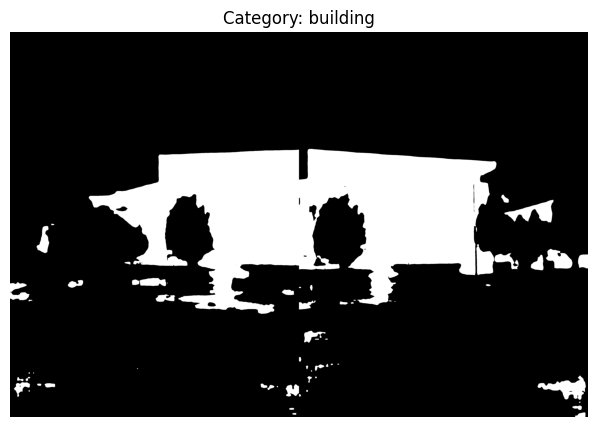

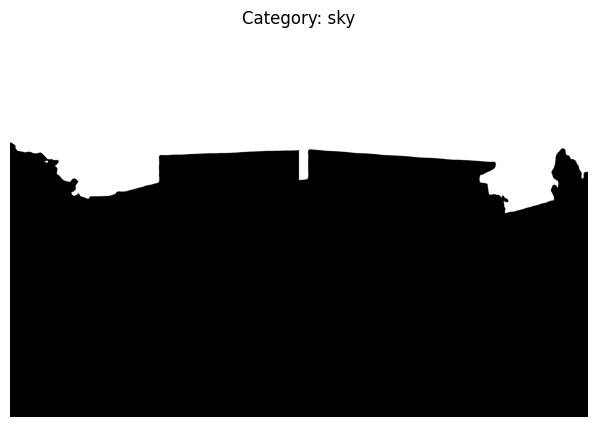

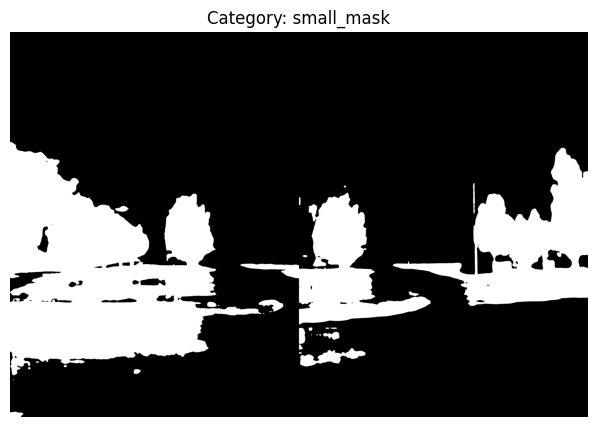

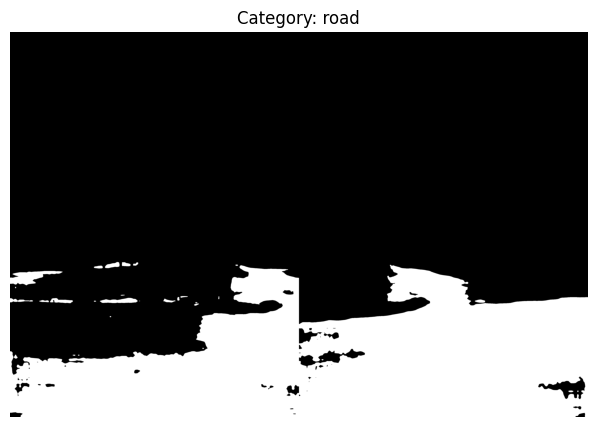

In [18]:
# Display masks side by side
display_masks_side_by_side(mask_dict1, mask_dict2)

In [19]:
class Image_Stitching:
    def __init__(self):
        self.ratio = 0.85
        self.min_match = 100
        self.sift = cv2.SIFT_create()
        self.smoothing_window_size = 800
        
    def apply_mask(self, img, mask):
        return cv2.bitwise_and(img, img, mask=mask)
        
    def resize_mask(self, img, mask):
        if len(mask.shape) == 3:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        if mask.dtype != np.uint8:
            mask = mask.astype(np.uint8)
        if mask.shape != img.shape[:2]:
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]))     
        return mask

    def registration(self, img1, img2, mask1, mask2):
        mask_1 = self.resize_mask(img1, mask1)
        mask_2 = self.resize_mask(img2, mask2)

        kp1, des1 = self.sift.detectAndCompute(img1, mask_1)
        kp2, des2 = self.sift.detectAndCompute(img2, mask_2)

        matcher = cv2.BFMatcher()
        raw_matches = matcher.knnMatch(des1, des2, k=2)
        good_points = []
        good_matches = []
        for m1, m2 in raw_matches:
            if m1.distance < self.ratio * m2.distance:
                good_points.append((m1.trainIdx, m1.queryIdx))
                good_matches.append([m1])
                
        img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
        plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
        plt.title('Matching')
        plt.show()
        
        if len(good_points) > self.min_match:
            image1_kp = np.float32([kp1[i].pt for (_, i) in good_points])
            image2_kp = np.float32([kp2[i].pt for (i, _) in good_points])
            H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC, 5.0)
            return H
        else:
            return None

    def create_mask(self, img1, img2, version):
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 + width_img2
        offset = int(self.smoothing_window_size / 2)
        barrier = img1.shape[1] - int(self.smoothing_window_size / 2)
        mask = np.zeros((height_panorama, width_panorama))
        if version == 'left_image':
            mask[:, barrier - offset:barrier + offset] = np.tile(np.linspace(1, 0, 2 * offset).T, (height_panorama, 1))
            mask[:, :barrier - offset] = 1
        else:
            mask[:, barrier - offset:barrier + offset] = np.tile(np.linspace(0, 1, 2 * offset).T, (height_panorama, 1))
            mask[:, barrier + offset:] = 1
        return cv2.merge([mask, mask, mask])

    def blending(self, img1, img2, mask1, mask2):
        H = self.registration(img1, img2, mask1, mask2)
        if H is None:
            print("Not enough matches found between the images.")
            return None
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 + width_img2

        panorama1 = np.zeros((height_panorama, width_panorama, 3), dtype=np.float32)
        mask1 = self.create_mask(img1, img2, version='left_image').astype(np.float32) / 255
        panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1.astype(np.float32) / 255
        panorama1 *= mask1

        # Normalize and convert to uint8
        #temp_panorama1 = cv2.normalize(panorama1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        #plt.imshow(cv2.cvtColor(temp_panorama1, cv2.COLOR_BGR2RGB))
        #plt.title('Panorama1')
        #plt.show()
    
        mask2 = self.create_mask(img1, img2, version='right_image').astype(np.float32) / 255
        panorama2 = cv2.warpPerspective(img2.astype(np.float32) / 255, H, (width_panorama, height_panorama))
        panorama2 *= mask2
        
        # Normalize and convert to uint8
        #temp_panorama2 = cv2.normalize(panorama2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        #plt.imshow(cv2.cvtColor(temp_panorama2, cv2.COLOR_BGR2RGB))
        #plt.title('Panorama2')
        #plt.show()
        
        result = panorama1 + panorama2       
        
        rows, cols = np.where(result[:, :, 0] != 0)
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1
        final_result = result[min_row:max_row, min_col:max_col, :]
        return final_result

    def process_dictionaries(self, img1, img2, mask_dict1, mask_dict2):
        homographies = {}
        for key1 in mask_dict1:
            category1 = mask_dict1[key1]['categories']
            for key2 in mask_dict2:
                category2 = mask_dict2[key2]['categories']
                if category1 == category2:
                    mask1 = mask_dict1[key1]['masks']
                    mask2 = mask_dict2[key2]['masks']
                    H = self.registration(img1, img2, mask1, mask2)
                    if H is not None:
                        homographies[category1] = H
                        print(f"Category: {category1}\nHomography Matrix:\n{H}\n")
                    else:
                        print(f"Not enough matches found for category: {category1}")
        return homographies

    def stitch_and_blend_with_labels(self, img1, img2, mask_dict1, mask_dict2):
        homographies = self.process_dictionaries(img1, img2, mask_dict1, mask_dict2)
        results = {}
        
        for category, H in homographies.items():
            for key in mask_dict1:
                if mask_dict1[key]['categories'] == category:
                    mask1 = mask_dict1[key]['masks']
            for key in mask_dict2:
                if mask_dict2[key]['categories'] == category:
                    mask2 = mask_dict2[key]['masks']
            final_result = self.blending(img1, img2, mask1, mask2)

            if final_result is not None:
                
                results[category] = final_result
                
                # Normalize and convert to uint8
                final_result = cv2.normalize(final_result, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
                plt.imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
                plt.title(f'Stitched and Blended Image - {category}')
                plt.show()

        return results

In [20]:
# Print the categories of each modified dictionary
# print_categories(mask_dict1, 'dict1')
# print_categories(mask_dict2, 'dict2')

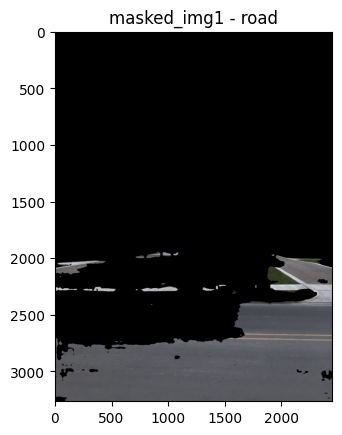

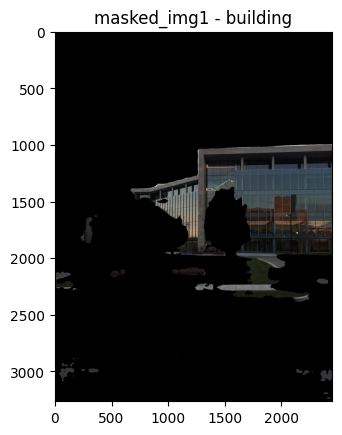

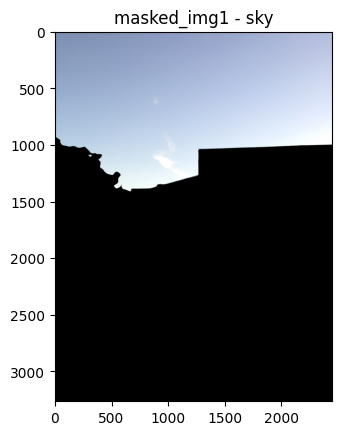

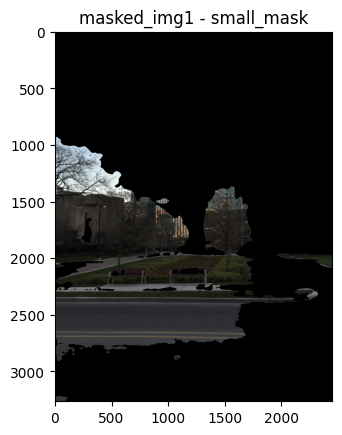

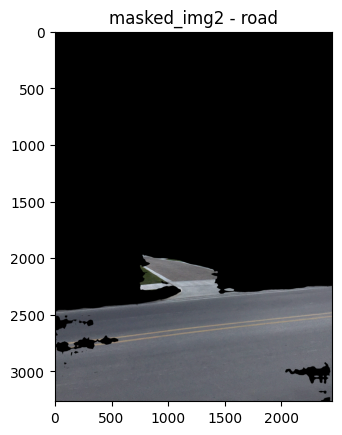

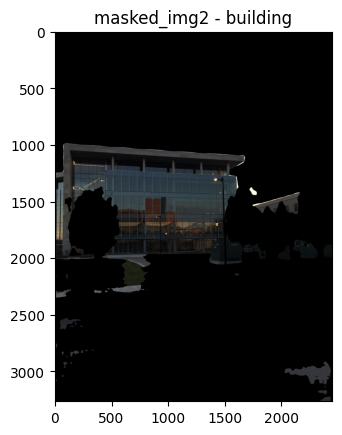

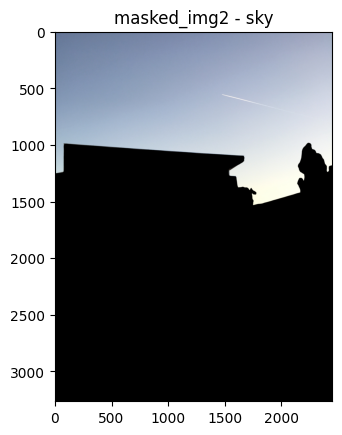

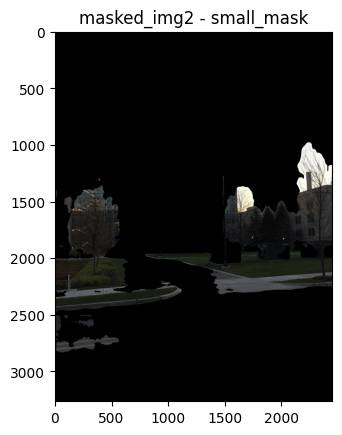

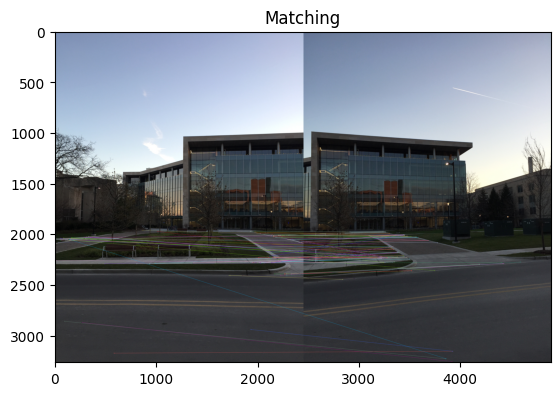

Category: road
Homography Matrix:
[[ 6.56654558e-01  1.14851308e-01  1.01679593e+03]
 [-2.62252966e-01  9.70883849e-01  8.74564562e+01]
 [-1.53357734e-04  1.74320176e-05  1.00000000e+00]]



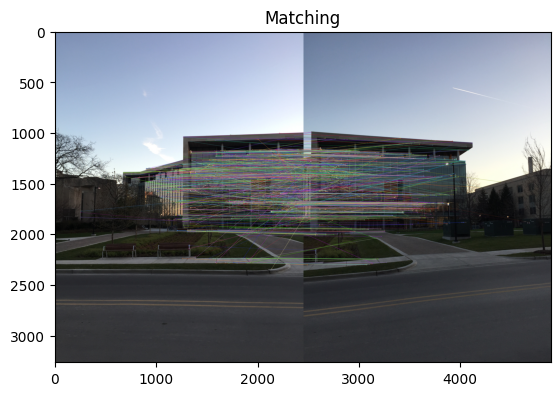

Category: building
Homography Matrix:
[[ 6.46746068e-01  8.99679769e-03  1.19171151e+03]
 [-2.44832337e-01  9.12199958e-01  1.47248315e+02]
 [-1.44336973e-04  2.77030996e-06  1.00000000e+00]]



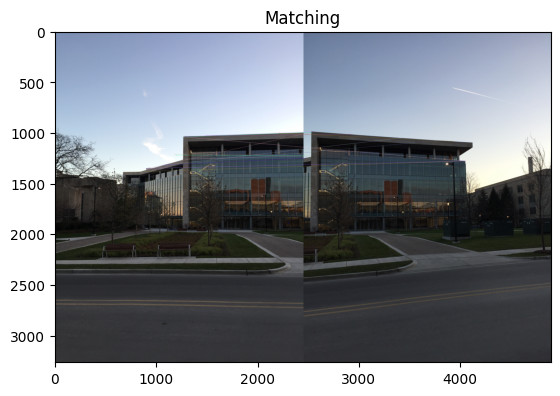

Not enough matches found for category: sky


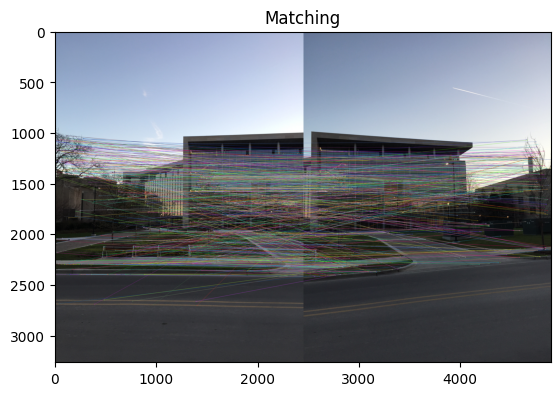

Category: small_mask
Homography Matrix:
[[ 6.58685141e-01 -1.40197698e-03  1.18794231e+03]
 [-2.09329397e-01  8.65023570e-01  1.78978511e+02]
 [-1.25923838e-04 -1.29202363e-05  1.00000000e+00]]



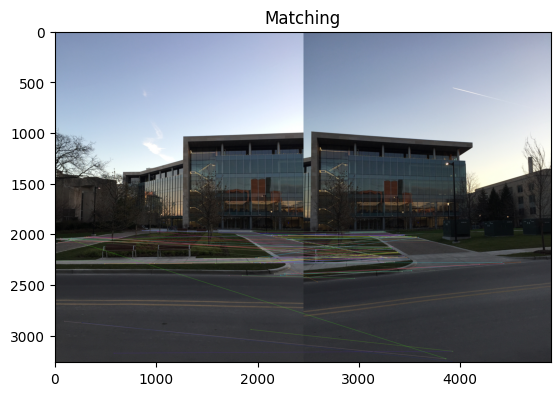

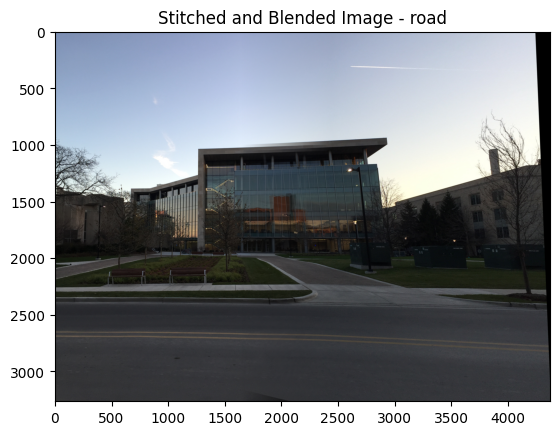

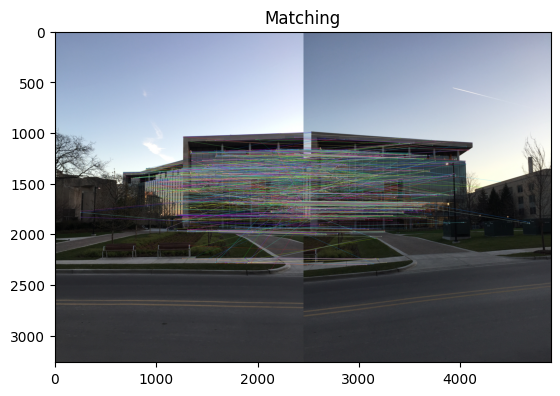

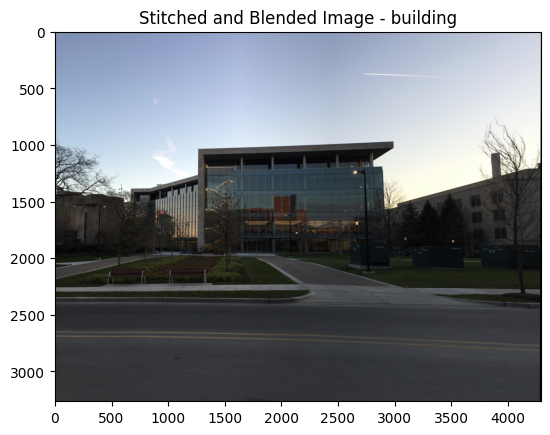

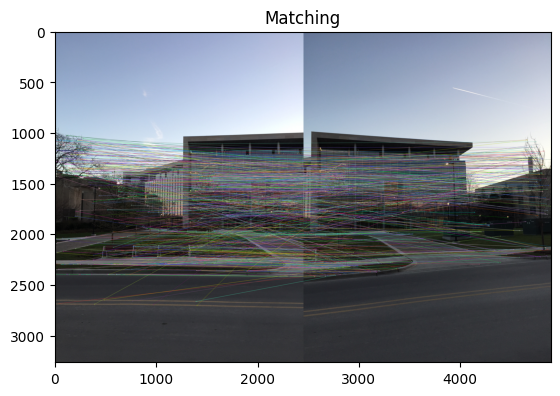

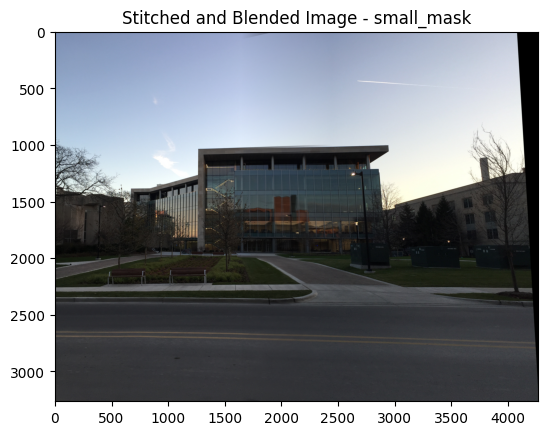

In [21]:
# Example usage
img1_path = 'image1.jpg'
img2_path = 'image2.jpg'
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

stitcher = Image_Stitching()

# Loop through mask_dict1 and display masked images
for key in mask_dict1:
    mask1 = mask_dict1[key]['masks']
    category = mask_dict1[key]['categories']
    
    masked_img1 = stitcher.resize_mask(img1, mask1)
    masked_img1 = stitcher.apply_mask(img1, masked_img1)
    masked_img1 = cv2.normalize(masked_img1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    plt.imshow(cv2.cvtColor(masked_img1, cv2.COLOR_BGR2RGB))
    plt.title(f'masked_img1 - {category}')
    plt.show()
    
# Loop through mask_dict1 and display masked images
for key in mask_dict2:
    mask2 = mask_dict2[key]['masks']
    category = mask_dict2[key]['categories']
    
    masked_img2 = stitcher.resize_mask(img2, mask2)
    masked_img2 = stitcher.apply_mask(img2, masked_img2)
    masked_img2 = cv2.normalize(masked_img2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    plt.imshow(cv2.cvtColor(masked_img2, cv2.COLOR_BGR2RGB))
    plt.title(f'masked_img2 - {category}')
    plt.show()

# Example usage for stitching and blending images with labels
results = stitcher.stitch_and_blend_with_labels(img1, img2, mask_dict1, mask_dict2)